## Dependencies

In [1]:
import os, time, warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from transformers import TFDistilBertModel
from tokenizers import BertWordPieceTokenizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
# Auxiliary functions
def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(20, 18))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()
    
def plot_confusion_matrix(y_train, train_pred, y_valid, valid_pred, labels=[0, 1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    train_cnf_matrix = confusion_matrix(y_train, train_pred)
    validation_cnf_matrix = confusion_matrix(y_valid, valid_pred)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

# Datasets
def get_training_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(repeated=False):
    dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset():
    dataset = tf.data.Dataset.from_tensor_slices(x_test)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

## TPU configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
train = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv", 
                    usecols=['comment_text', 'toxic'])
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv', 
                    usecols=['comment_text', 'toxic'])
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv', 
                   usecols=['content'])

print('Train samples %d' % len(train))
display(train.head())
print('Validation samples %d' % len(valid))
display(valid.head())

Train samples 223549


,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Validation samples 8000


,comment_text,toxic
0,Este usuario ni siquiera llega al rango de ...,0
1,Il testo di questa voce pare esser scopiazzato...,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,1
3,Bu maddenin alt başlığı olarak uluslararası i...,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,0


# Model parameters

In [5]:
MAX_LEN = 512
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
EPOCHS = 20
LEARNING_RATE = 1e-5 # * strategy.num_replicas_in_sync
ES_PATIENCE = 6
TRAIN_STEPS = len(train) // BATCH_SIZE
VALIDATION_STEPS = len(valid) // BATCH_SIZE

base_model_path = '/kaggle/input/diltilbert-base-ml-cased-huggingface/distilbert-base-multilingual-cased-tf_model.h5'
config_path = '/kaggle/input/diltilbert-base-ml-cased-huggingface/distilbert-base-multilingual-cased-config.json'
vocab_path = '/kaggle/input/diltilbert-base-ml-cased-huggingface/bert-base-multilingual-cased-vocab.txt'
model_path = 'model.h5'

## Tokenizer

In [6]:
tokenizer = BertWordPieceTokenizer(vocab_path, lowercase=False)
tokenizer.enable_truncation(max_length=MAX_LEN)
tokenizer.enable_padding(max_length=MAX_LEN)

## Build TF datasets

In [7]:
x_train = [x.ids for x in tokenizer.encode_batch(train['comment_text'].apply(lambda x : x).tolist())]
x_valid = [x.ids for x in tokenizer.encode_batch(valid['comment_text'].apply(lambda x : x).tolist())]
x_test = [x.ids for x in tokenizer.encode_batch(test['content'].apply(lambda x : x).tolist())]

#  Labels needs to be reshaped
y_train = train['toxic'].values.reshape(len(x_train), 1)
y_valid = valid['toxic'].values.reshape(len(x_valid), 1)

AUTO = tf.data.experimental.AUTOTUNE

# distribute the datset according to the strategy
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset())
# Hitting End Of Dataset exceptions is a problem in this setup. Using a repeated validation set instead.
# This will introduce a slight inaccuracy because the validation dataset now has some repeated elements.
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(repeated=True))

train_data_iter = iter(train_dist_ds) # the training data iterator is repeated and it is not reset
                                      # for each validation run (same as model.fit)
valid_data_iter = iter(valid_dist_ds) # the validation data iterator is repeated and it is not reset
                                      # for each validation run (different from model.fit whre the  
                                      # recommendation is to use a non-repeating validation dataset)

# Learning rate schedule

Learning rate schedule: 1e-09 to 1e-05 to 1.4e-06


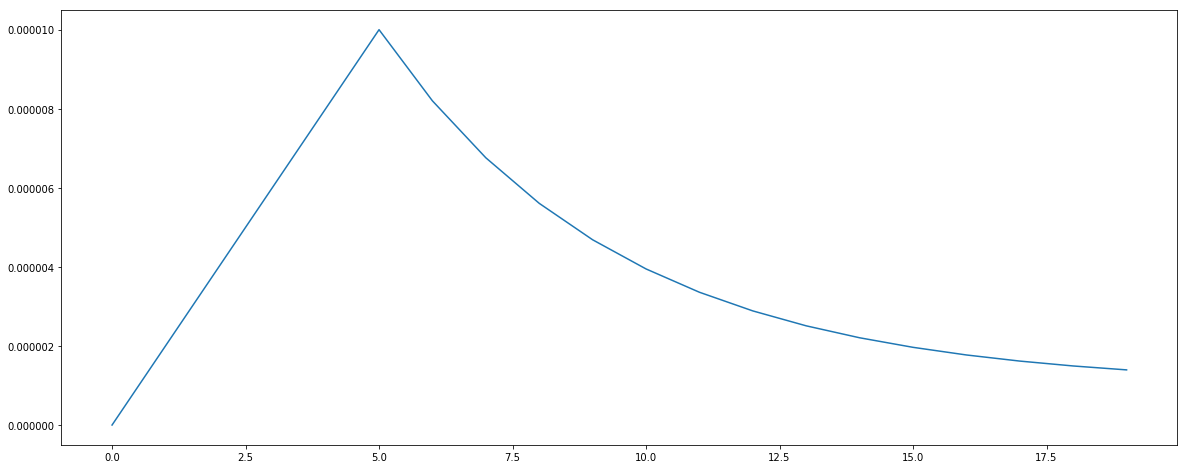

In [8]:
LR_START = 1e-9
LR_MIN = 1e-6
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

@tf.function
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
def model_fn():
    input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    base_model = TFDistilBertModel.from_pretrained(base_model_path, config=config_path)
    sequence_output = base_model(input_word_ids)[0]
    
    x = GlobalAveragePooling1D()(sequence_output)
    x = Dropout(0.25)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_word_ids, outputs=output)
    
    return model

### Step functions

In [10]:
@tf.function
def train_step(data_iter):
    def train_step_fn(images, labels):
        with tf.GradientTape() as tape:
            probabilities = model(images, training=True)
            loss = loss_fn(labels, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_accuracy.update_state(labels, probabilities)
        train_auc.update_state(labels, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(TRAIN_STEPS):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(images, labels):
        probabilities = model(images, training=False)
        loss = loss_fn(labels, probabilities)
        valid_accuracy.update_state(labels, probabilities)
        valid_auc.update_state(labels, probabilities)
        valid_loss.update_state(loss)
    for _ in tf.range(VALIDATION_STEPS):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

In [11]:
with strategy.scope():
    model = model_fn()

    # Instiate optimizer with learning rate schedule
    class LRSchedule(optimizers.schedules.LearningRateSchedule):
        def __call__(self, step):
            return lrfn(epoch=step//TRAIN_STEPS)
    optimizer = optimizers.Adam(learning_rate=LRSchedule())

    train_accuracy = metrics.BinaryAccuracy()
    train_auc = metrics.AUC()
    train_loss = metrics.Sum()
    valid_accuracy = metrics.BinaryAccuracy()
    valid_auc = metrics.AUC()
    valid_loss = metrics.Sum()

    loss_fn = losses.binary_crossentropy

# Optimized training loop

In [12]:
step = 0
epoch = 0
epoch_steps = 0
epoch_start_time = time.time()
history = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': [], 
           'accuracy': [], 'val_accuracy': []}
patience_cnt = 0
best_val = float("inf")

### Train model
print('Train for %d steps, validate for %d steps' % (TRAIN_STEPS, VALIDATION_STEPS))
while True:
    # run training step
    train_step(train_data_iter)
    epoch_steps += TRAIN_STEPS
    step += TRAIN_STEPS

    # validation run at the end of each epoch
    if (step // TRAIN_STEPS) > epoch:
        # validation run
        valid_epoch_steps = 0
        valid_step(valid_data_iter)
        valid_epoch_steps += VALIDATION_STEPS

        # compute metrics
        history['accuracy'].append(train_accuracy.result().numpy())
        history['auc'].append(train_auc.result().numpy())
        history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE*epoch_steps))
        history['val_accuracy'].append(valid_accuracy.result().numpy())
        history['val_auc'].append(valid_auc.result().numpy())
        history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE*valid_epoch_steps))

        # report metrics
        epoch_time = time.time() - epoch_start_time
        print('\nEPOCH {:d}/{:d}'.format(epoch+1, EPOCHS))
        print('time: {:0.1f}s'.format(epoch_time),
              'loss: {:0.4f}'.format(history['loss'][-1]),
              'auc: {:0.4f}'.format(history['auc'][-1]),
              'accuracy: {:0.4f}'.format(history['accuracy'][-1]),
              'val_loss: {:0.4f}'.format(history['val_loss'][-1]),
              'val_auc: {:0.4f}'.format(history['val_auc'][-1]),
              'val_accuracy: {:0.4f}'.format(history['val_accuracy'][-1])
             )
        print('LearningRate: {:0.4g}'.format(lrfn(epoch)))

        # set up next epoch
        epoch = step // TRAIN_STEPS
        epoch_steps = 0
        epoch_start_time = time.time()
        train_accuracy.reset_states()
        train_auc.reset_states()
        train_loss.reset_states()
        valid_accuracy.reset_states()
        valid_auc.reset_states()
        valid_loss.reset_states()
        if epoch >= EPOCHS:
            model.save_weights(model_path)
            break

        # Early stopping monitor
        if history['val_loss'][-1] <= best_val:
            best_val = history['val_loss'][-1]
            model.save_weights(model_path)
            print('Saved model weights at "%s"' % model_path)
        else:
            patience_cnt += 1
        if patience_cnt > ES_PATIENCE:
            print('Epoch %05d: early stopping' % epoch)
            break

Train for 436 steps, validate for 15 steps

EPOCH 1/20
time: 299.2s loss: 0.5330 auc: 0.4697 accuracy: 0.8438 val_loss: 0.5439 val_auc: 0.4697 val_accuracy: 0.8327
LearningRate: 1e-09
Saved model weights at "model.h5"

EPOCH 2/20
time: 242.1s loss: 0.2722 auc: 0.7543 accuracy: 0.9088 val_loss: 0.4382 val_auc: 0.6833 val_accuracy: 0.8230
LearningRate: 2.001e-06
Saved model weights at "model.h5"

EPOCH 3/20
time: 242.8s loss: 0.1617 auc: 0.9349 accuracy: 0.9392 val_loss: 0.4537 val_auc: 0.7599 val_accuracy: 0.8473
LearningRate: 4.001e-06

EPOCH 4/20
time: 239.7s loss: 0.1254 auc: 0.9637 accuracy: 0.9505 val_loss: 0.4954 val_auc: 0.7911 val_accuracy: 0.8443
LearningRate: 6e-06

EPOCH 5/20
time: 239.7s loss: 0.1088 auc: 0.9737 accuracy: 0.9565 val_loss: 0.5310 val_auc: 0.7868 val_accuracy: 0.8508
LearningRate: 8e-06

EPOCH 6/20
time: 239.7s loss: 0.1000 auc: 0.9782 accuracy: 0.9591 val_loss: 0.6456 val_auc: 0.7532 val_accuracy: 0.8484
LearningRate: 1e-05

EPOCH 7/20
time: 239.7s loss: 0.09

## Model loss graph

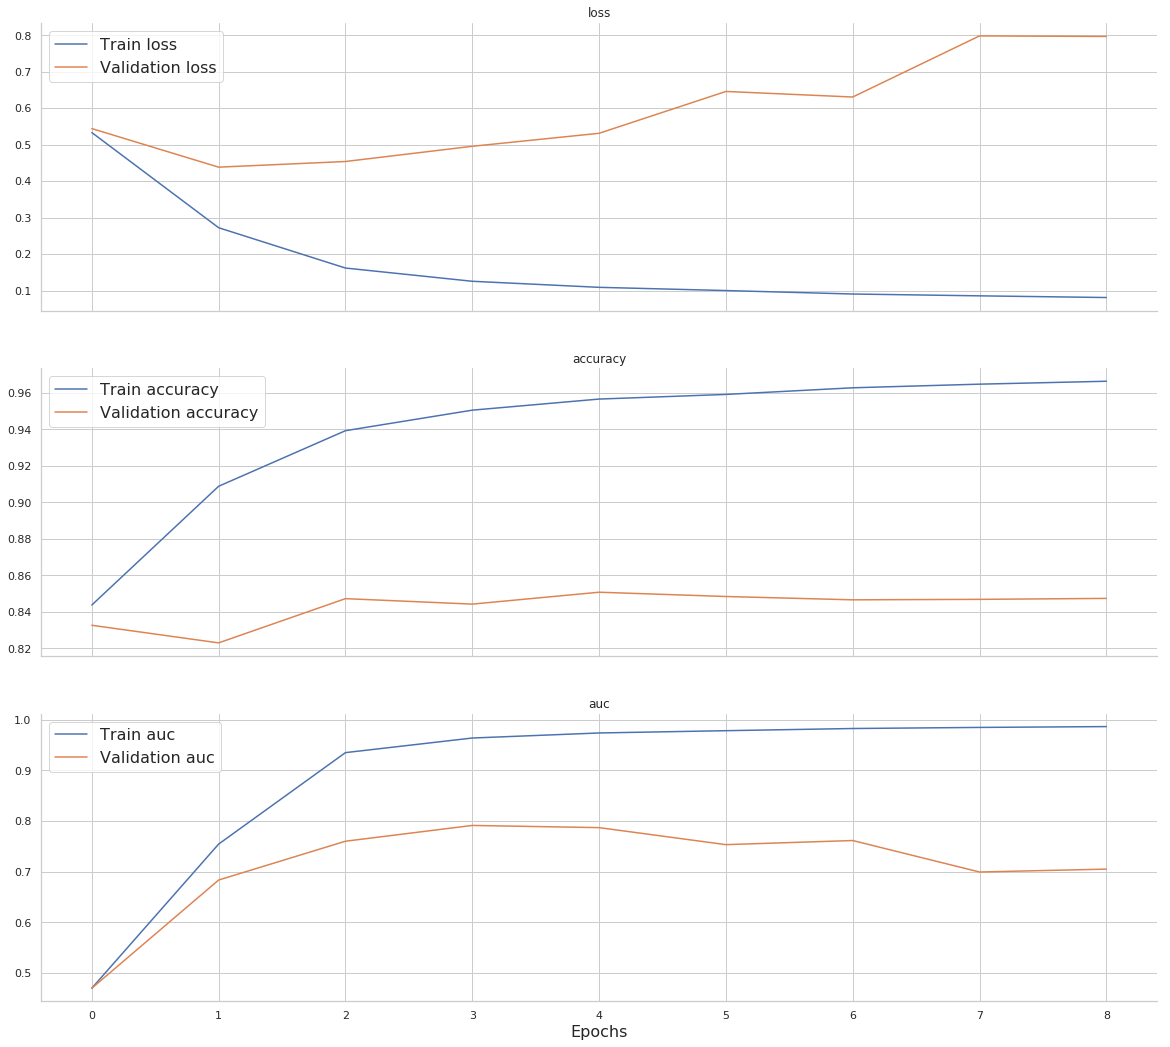

In [13]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'accuracy', 'auc'])

# Model evaluation

In [14]:
model.load_weights(model_path)

train_pred = model.predict(get_training_dataset(), steps=TRAIN_STEPS)
valid_pred = model.predict(get_validation_dataset())
train = train[:len(train_pred)]
valid = valid[:len(valid_pred)]
train['pred'] = train_pred
valid['pred'] = valid_pred

print('Train set ROC AUC %.4f' % roc_auc_score(train['toxic'], train['pred']))
print(classification_report(train['toxic'],  np.round(train['pred'])))
print('Validation set ROC AUC %.4f' % roc_auc_score(valid['toxic'], valid['pred']))
print(classification_report(valid['toxic'],  np.round(valid['pred'])))

Train set ROC AUC 0.5025
              precision    recall  f1-score   support

           0       0.90      0.90      0.90    201868
           1       0.10      0.10      0.10     21364

    accuracy                           0.83    223232
   macro avg       0.50      0.50      0.50    223232
weighted avg       0.83      0.83      0.83    223232

Validation set ROC AUC 0.6930
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6494
           1       0.37      0.25      0.30      1186

    accuracy                           0.82      7680
   macro avg       0.62      0.59      0.60      7680
weighted avg       0.79      0.82      0.80      7680



# Confusion matrix

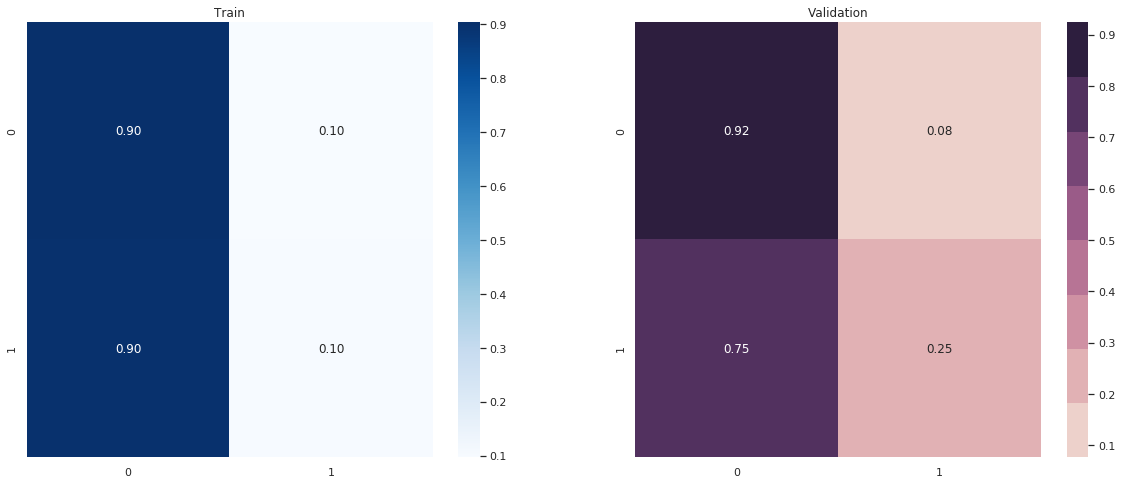

In [15]:
plot_confusion_matrix(train['toxic'], np.round(train['pred']), 
                      valid['toxic'], np.round(valid['pred']))

# Visualize predictions

In [16]:
print('Train set')
display(train[['comment_text', 'toxic', 'pred']].head(10))
print('Validation set')
display(valid[['comment_text', 'toxic', 'pred']].head(10))

Train set


,comment_text,toxic,pred
0,Explanation\nWhy the edits made under my usern...,0,0.166990
1,D'aww! He matches this background colour I'm s...,0,0.024660
2,"Hey man, I'm really not trying to edit war. It...",0,0.049777
3,"""\nMore\nI can't make any real suggestions on ...",0,0.029436
4,"You, sir, are my hero. Any chance you remember...",0,0.030661
5,"""\n\nCongratulations from me as well, use the ...",0,0.034499
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,0.181158
7,Your vandalism to the Matt Shirvington article...,0,0.054721
8,Sorry if the word 'nonsense' was offensive to ...,0,0.013731
9,alignment on this subject and which are contra...,0,0.072468


Validation set


,comment_text,toxic,pred
0,Este usuario ni siquiera llega al rango de ...,0,0.167612
1,Il testo di questa voce pare esser scopiazzato...,0,0.083813
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,1,0.083050
3,Bu maddenin alt başlığı olarak uluslararası i...,0,0.346665
4,Belçika nın şehirlerinin yanında ilçe ve belde...,0,0.304965
5,"güzel, zaten kaynaklandırması zor subjektif ka...",0,0.484324
6,"No es mala idea. De hecho, yo estaba pensando ...",0,0.142654
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık ç...",0,0.197380
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umar...,0,0.302111
9,Creo que es importante que podamos reconocer a...,0,0.248793
